In [1]:
import torch
from torch import nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import os
import random
import ast
import music21
import textract
import pathlib
from collections import defaultdict
from collections import Counter
import networkx as nx
import seaborn as sns

In [12]:
data_train = pd.read_csv('./train.csv')
data_train['beat_pitch'] = data_train['beat_pitch'].apply(ast.literal_eval)
data_train['pitches'] = data_train['pitches'].apply(ast.literal_eval)

In [15]:
high=0
low=0
for i in range(len(data_train['pitches'])):
    piece=data_train['pitches'][i]  
    piece=np.array(sum(piece,[]))    
    if high<np.max(piece):
        high=np.max(piece)
    if low>np.min(piece):
        low=np.min(piece)
print(high)
print(low)

89
0


In [16]:
def format_transition_1(piece):
    # Transfer the beat_pitch format to 12-position 1-12 scale format
    # arg: 1.piece: one piece of music in beat_pitch format
    # return: 1.re: the transfer format of the piece, re is in shape of number_of_bars * 12
    re=np.zeros((len(piece),12))
    for i in range(len(piece)):
        bar=piece[i]
        for j in range(len(bar)):            
            re[i][bar[j][0]-1]=bar[j][1]/high
    return re

In [25]:
INPUT_SIZE=12    # number of notes for one prediction
HIDDEN_SIZE=15   # size of the hidden units
NUM_LAYERS=1
NUM_DIRECTION=1
Bidirectional=False
SEQ_LEN=8    # number of bars for one prediction
BATCH_SIZE=50
OUTPUT_SIZE=12    # number of notes for predicted result
lr=0.001
if(NUM_DIRECTION==1):
    Bidirectional = False
else:
    Bidirectional = True
ITERATION=5
EPOCH=5
EPOCH_LOSS_FIG_POSITION=".//loss"

In [26]:
class LSTM(nn.Module):
    def __init__(self, INPUT_SIZE,HIDDEN_SIZE,NUM_LAYERS,Bidirectional):
        super(LSTM, self).__init__()

        self.LSTM = nn.LSTM(
            input_size=INPUT_SIZE,
            hidden_size=HIDDEN_SIZE,
            num_layers=NUM_LAYERS,
            bias=True,
            batch_first=True,
            dropout=0,
            bidirectional=Bidirectional,
            proj_size=0
        )

        self.out = nn.Linear(HIDDEN_SIZE*SEQ_LEN,OUTPUT_SIZE)

    def forward(self, x, hidden_state):
        output, h_state = self.LSTM(x,hidden_state)
        outs = []  #for different batch
        for time in range(output.size(0)):
            outs.append(self.out(output[time, :, :].reshape(-1)))            
        return torch.stack(outs, dim=1), h_state

In [27]:
def train():
    model = LSTM(INPUT_SIZE,HIDDEN_SIZE,NUM_LAYERS,Bidirectional)
    print('model:\n', model)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr)
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
    h_0 = torch.normal(1, 0.2, size=(NUM_LAYERS*NUM_DIRECTION,BATCH_SIZE, HIDDEN_SIZE))  #initialize hidden_state
    c_0 = torch.normal(1, 0.2, size=(NUM_LAYERS*NUM_DIRECTION,BATCH_SIZE, HIDDEN_SIZE))
    hidden_state=(h_0,c_0)   
      
    for ep in range(1,EPOCH+1):
        loss_epoch=[]   
        counter=0
        for iter in range(1,ITERATION+1):
            x =[]
            y=[]    
            i=0           
            while(i!=BATCH_SIZE):                
                j=0
                piece_now=format_transition_1(data_train['beat_pitch'][counter])     
                x_x=[]
                try:
                    while(j!=SEQ_LEN):                                        
                        x_x.append(piece_now[j])                          
                        j=j+1  
                    a=piece_now[SEQ_LEN] # Just for filter out the piece whose number of bars<SEQ_LEN
                except IndexError:
                    counter=counter+1  
                    continue
                counter=counter+1
                i=i+1
                x.append(x_x)
                y.append(piece_now[SEQ_LEN])
                
                
            x=np.array(x)            
            x = x.reshape([BATCH_SIZE, SEQ_LEN, INPUT_SIZE])
            x=torch.tensor(x,dtype=torch.float32)
            y=np.array(y)        
            y=y.reshape([INPUT_SIZE,BATCH_SIZE])
            y=torch.tensor(y,dtype=torch.float32)
            output, hidden_state = model(x, hidden_state)           
            h_0, c_0 = hidden_state
            h_0.detach_()
            c_0.detach_()
            hidden_state = (h_0, c_0)
            print(iter)           
            model.zero_grad()
            loss=criterion(output, y)
            loss_epoch.append(loss.item())
            print("loss: "+str(loss))
            torch.autograd.set_detect_anomaly(True)
            #with torch.autograd.detect_anomaly():
                #loss.backward()
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(),max_norm=2)
            optimizer.step()
        plot_EPOCH_LOSS(loss_epoch,ep)
        scheduler.step()



model:
 LSTM(
  (LSTM): LSTM(12, 15, batch_first=True)
  (out): Linear(in_features=120, out_features=12, bias=True)
)
1
loss: tensor(0.4554, grad_fn=<MseLossBackward>)
2
loss: tensor(0.5235, grad_fn=<MseLossBackward>)
3
loss: tensor(0.4503, grad_fn=<MseLossBackward>)
4
loss: tensor(0.4583, grad_fn=<MseLossBackward>)
5
loss: tensor(0.4408, grad_fn=<MseLossBackward>)
1
loss: tensor(0.3675, grad_fn=<MseLossBackward>)
2
loss: tensor(0.4203, grad_fn=<MseLossBackward>)
3
loss: tensor(0.3630, grad_fn=<MseLossBackward>)
4
loss: tensor(0.3708, grad_fn=<MseLossBackward>)
5
loss: tensor(0.3556, grad_fn=<MseLossBackward>)
1
loss: tensor(0.2963, grad_fn=<MseLossBackward>)
2
loss: tensor(0.3380, grad_fn=<MseLossBackward>)
3
loss: tensor(0.2942, grad_fn=<MseLossBackward>)
4
loss: tensor(0.3000, grad_fn=<MseLossBackward>)
5
loss: tensor(0.2862, grad_fn=<MseLossBackward>)
1
loss: tensor(0.2406, grad_fn=<MseLossBackward>)
2
loss: tensor(0.2699, grad_fn=<MseLossBackward>)
3
loss: tensor(0.2397, grad_fn=<

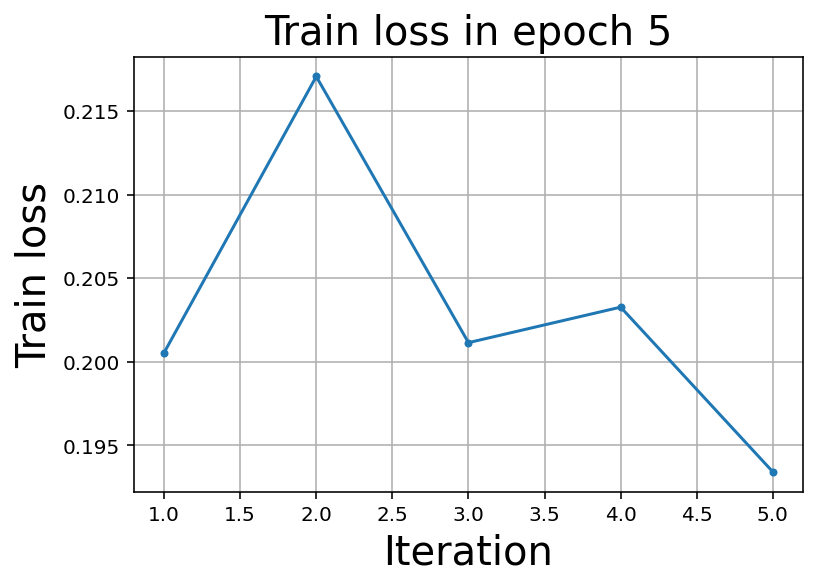

In [28]:
def plot_EPOCH_LOSS(loss_list,epoch):
    plt.cla()
    x1 = range(1, len(loss_list)+1)
    y1 = loss_list
    plt.title('Train loss in epoch {}'.format(epoch), fontsize=20)
    plt.plot(x1, y1, '.-')
    plt.xlabel('Iteration', fontsize=20)
    plt.ylabel('Train loss', fontsize=20)
    plt.grid()
    plt.savefig(EPOCH_LOSS_FIG_POSITION+"//"+"{}.png".format(epoch))

train()